In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# EDA

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/sample_submission.csv')

In [3]:
train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9473 entries, 0 to 9472
Data columns (total 3 columns):
fname                9473 non-null object
label                9473 non-null object
manually_verified    9473 non-null int64
dtypes: int64(1), object(2)
memory usage: 222.1+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 2 columns):
fname    9400 non-null object
label    9400 non-null object
dtypes: object(2)
memory usage: 147.0+ KB


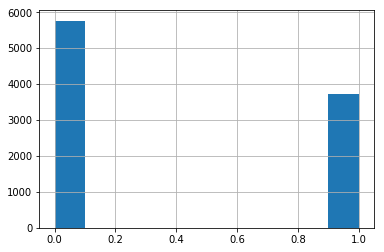

In [6]:
train['manually_verified'].hist()

## explore class distribution

In [7]:
train['label'].value_counts()

Applause                 300
Squeak                   300
Acoustic_guitar          300
Cello                    300
Bass_drum                300
Trumpet                  300
Snare_drum               300
Tearing                  300
Violin_or_fiddle         300
Fireworks                300
Fart                     300
Shatter                  300
Flute                    300
Hi-hat                   300
Laughter                 300
Double_bass              300
Saxophone                300
Clarinet                 300
Oboe                     299
Gong                     292
Knock                    279
Writing                  270
Cough                    243
Bark                     239
Tambourine               221
Burping_or_eructation    210
Cowbell                  191
Harmonica                165
Drawer_open_or_close     158
Meow                     155
Electric_piano           150
Gunshot_or_gunfire       147
Microwave_oven           146
Keys_jangling            139
Telephone     

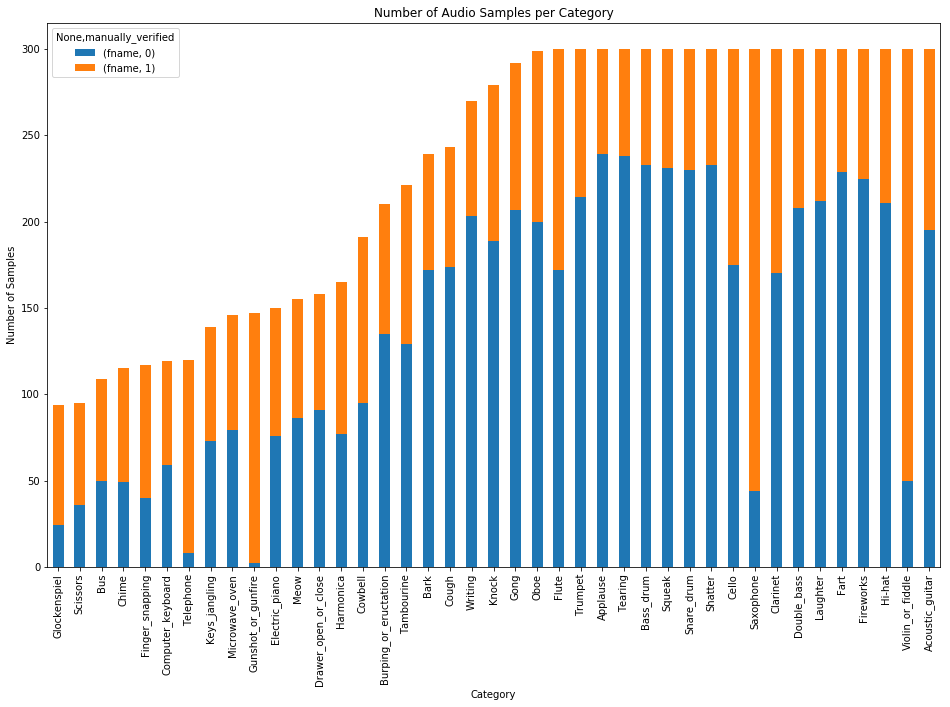

In [8]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [9]:
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


#### not the same number of audio samples for every class and some of the classes have been more manually verified than others

## exploring audio data

In [10]:
import IPython.display as ipd  # To play sound in the notebook
fname = 'data/audio_train/' + 'ffd6b26c.wav'   # clarinet
ipd.Audio(fname)

## interacting with the wave files

### using scipy

In [11]:
from scipy.io import wavfile

In [12]:
rate,data = wavfile.read(fname)

In [13]:
rate #sampling rate

44100

In [14]:
data.shape#total number of samples

(94374,)

In [15]:
#data.dtype

## exploring audio lengths

In [16]:
def get_nframes(fname):
    rate, data = wavfile.read(fname)
    return data.shape[0]

In [17]:
train['n_frames'] = train['fname'].apply(lambda fname: get_nframes(f'data/audio_train/{fname}'))

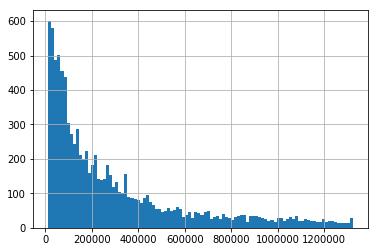

In [18]:
train['n_frames'].hist(bins=100)

#### need to be pad the shorter audio files to make them all the same length, or break up the bigger files.

### exploring audio amplitudes

In [19]:
def get_amplitude(fname):
    rate, data = wavfile.read(fname)
    return max(data)

In [20]:
train['amplitude'] = train['fname'].apply(lambda fname: get_amplitude(f'data/audio_train/{fname}'))

KeyboardInterrupt: 

In [ ]:
train['amplitude'].hist(bins=100)

#### definitely needs normalization.

In [21]:
def normalize_audio(audio):
    return audio/max(audio)

### visualize audio file

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data)

In [ ]:
import wave

In [ ]:
wav = wave.open(fname)

In [ ]:
wav.getnframes()#gets number of frames in the wave file

In [51]:
import librosa.display

In [46]:
fname ='data/audio_train/' + '05d0dfa7.wav' 
data, rate = librosa.load(fname,sr=24000,duration=2)
S = librosa.feature.melspectrogram(normalize_audio(data),rate,n_mels=128,fmax=24000)
len(S)

/anaconda3/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


128

In [47]:
len(data)/rate

2.0000416666666667

In [48]:
len(S[0])/60

1.5666666666666667

In [49]:
2*60

120

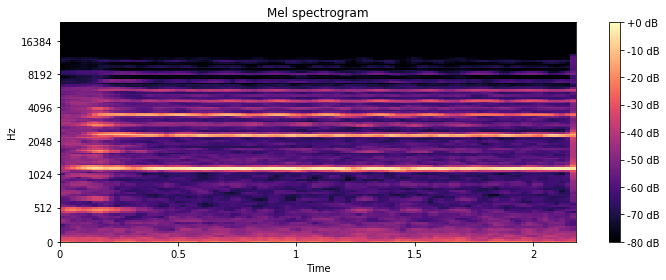

In [52]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,
 ref=np.max),
y_axis='mel', fmax=24000,
x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

# Modeling

### set this to true if you want to work with full data

In [ ]:
# full_data = False

In [ ]:
# if not full_data:
#     train = train.sample(1000)
#     test = test.sample(1000)

In [22]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution1D,MaxPooling1D,ZeroPadding1D
from keras.layers import GlobalMaxPooling1D
from keras import optimizers

Using TensorFlow backend.


## baseline 1d CNN on raw waveforms

In [23]:
import keras.utils.data_utils as d_utils
import keras.utils.np_utils as n_utils

Sequence are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.

In [24]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mel_spec=False,
                 n_mels=128,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.use_mel_spec = use_mel_spec
        self.n_mels = n_mels
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        elif self.use_mel_spec:
            self.dim = (n_mels, self.audio_duration*60)
        else:
            self.dim = (self.audio_length, 1)

In [34]:
class DataGenerator(d_utils.Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None, 
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        
    def transform_data(self,data):
        if self.config.use_mfcc:
            data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                               n_mfcc=self.config.n_mfcc)
            data = np.expand_dims(data, axis=-1)
        elif self.config.use_mel_spec:
            data = librosa.feature.melspectrogram(data,sr=self.config.sampling_rate,n_mels=self.config.n_mels)
        else:
            data = self.preprocessing_fn(data)[:, np.newaxis]
        return data
    
    def adjust_audio_length(self,data,input_length):
       # print("adjusted audio length")
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
       # print(len(data))
        return data
#             if len(data) >= input_length:
#                 data = data[:input_length]
#             else:
#                 data = np.pad(data,input_length-len(data),"constant")
    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')
            
            #fixing lengths of files
            # Random offset / Padding
            data = self.adjust_audio_length(data,input_length)
            #other preprocessing
            data = self.transform_data(data)
         
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, n_utils.to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

In [25]:
def get_1d_dummy_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    model = Sequential()
    model.add(Convolution1D(nb_filter=512, filter_length=1, input_shape=(input_length, 3)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(nclass))
    model.add(Activation('softmax'))
    opt = optimizers.Adam()

#     model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
    return model

In [26]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [27]:
def get_conv_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
#     inp = Input(shape=(input_length,1))
    model = Sequential()
    model.add(Convolution1D(16, 9, activation='relu', padding="valid",input_shape=(input_length,1)))
    model.add(Convolution1D(16, 9, activation='relu', padding="valid"))
    model.add(MaxPooling1D(16))
    model.add(Dropout(rate=0.1))
    
    model.add(Convolution1D(32, 3, activation='relu', padding="valid"))
    model.add(Convolution1D(32, 3, activation='relu', padding="valid"))
    model.add(MaxPooling1D(4))
    model.add(Dropout(rate=0.1))
    
    model.add(Convolution1D(32, 3, activation='relu', padding="valid"))
    model.add(Convolution1D(32, 3, activation='relu', padding="valid"))
    model.add(MaxPooling1D(4))
    model.add(Dropout(rate=0.1))
    
    model.add(Convolution1D(256, 3, activation='relu', padding="valid"))
    model.add(Convolution1D(256, 3, activation='relu', padding="valid"))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate=0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1028, activation='relu'))
    model.add(Dense(nclass, activation='softmax'))

    opt = optimizers.Adam(config.learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
    return model

In [28]:
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])

In [29]:
import os
from sklearn.cross_validation import StratifiedKFold
import librosa
import shutil

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)

In [45]:
def train_test_model(train, config, quick_run=False):
    if quick_run:
        train = train.sample(2000)
        config = Config(sampling_rate=100, audio_duration=1, n_folds=2, max_epochs=1)

    PREDICTION_FOLDER = "predictions_1d_conv"
    if not os.path.exists(PREDICTION_FOLDER):
        os.mkdir(PREDICTION_FOLDER)
    if os.path.exists('logs/' + PREDICTION_FOLDER):
        shutil.rmtree('logs/' + PREDICTION_FOLDER)

    skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds)

    for i, (train_split, val_split) in enumerate(skf):
        train_set = train.iloc[train_split]
        val_set = train.iloc[val_split]
        checkpoint = ModelCheckpoint(f'best_{i}.h5', monitor='val_loss', verbose=1, save_best_only=True)
        early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
        tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)

        callbacks_list = [checkpoint, early, tb]
        #callbacks_list = [early]
        print("Fold: ", i)
        print("#"*50)
        if not quick_run:
            model = get_conv_model(config)
        else:
            model = get_1d_dummy_model(config)
        train_generator = DataGenerator(config, 'data/audio_train/', train_set.index, 
                                        train_set.label_idx, batch_size=64,
                                        preprocessing_fn=normalize_audio)
        val_generator = DataGenerator(config, 'data/audio_train/', val_set.index, 
                                      val_set.label_idx, batch_size=64,
                                      preprocessing_fn=normalize_audio)

        history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                      epochs=config.max_epochs, use_multiprocessing=True, workers=6, max_queue_size=20)

        model.load_weights(f'best_{len(.h5')

        # Save train predictions
        train_generator = DataGenerator(config, 'data/audio_train/', train.index, batch_size=128,
                                        preprocessing_fn=normalize_audio)
        predictions = model.predict_generator(train_generator, use_multiprocessing=True, 
                                              workers=6, max_queue_size=20, verbose=1)
        np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

        # Save test predictions
        test_generator = DataGenerator(config, 'data/audio_test/', test.index, batch_size=128,
                                        preprocessing_fn=normalize_audio)
        predictions = model.predict_generator(test_generator, use_multiprocessing=True, 
                                              workers=6, max_queue_size=20, verbose=1)
        np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

        #Make a submission file
        top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
        predicted_labels = [' '.join(list(x)) for x in top_3]
        test['label'] = predicted_labels
        test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)
        #model.save_weights(f'best_{i}.h5')
    model = get_conv_model(config)
    model.load_weights(f"best_{len(skd)-1}"")
    model.save('best_model.h5')

In [54]:
config = Config(sampling_rate=10000, audio_duration=1, n_folds=2, learning_rate=0.001,max_epochs=1)

In [55]:
model = get_conv_model(config)

In [56]:
model.load_weights('best_1.h5')

In [57]:
model.save("best_model.h5")

In [42]:
train_test_model(train,config)

Fold:  0
##################################################
Epoch 1/5
 8/74 [==>...........................] - ETA: 5:35 - loss: 3.7105 - acc: 0.0273

Process ForkPoolWorker-40:
Process ForkPoolWorker-46:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-48:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-39:
Process ForkPoolWorker-43:
Process ForkPoolWorker-47:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessi

KeyboardInterrupt: 

Process ForkPoolWorker-44:
  File "<ipython-input-34-727bd16aa5bb>", line 64, in __data_generation
    res_type='kaiser_fast')
  File "/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py", line 160, in load
    y = resample(y, sr_native, sr, res_type=res_type)
  File "/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py", line 286, in resample
    y_hat = resampy.resample(y, orig_sr, target_sr, filter=res_type, axis=-1)
  File "/anaconda3/lib/python3.6/site-packages/resampy/core.py", line 113, in resample
    resample_f(x_2d, y_2d, sample_ratio, interp_win, interp_delta, precision)
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwd

  File "/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "<ipython-input-34-727bd16aa5bb>", line 19, in __getitem__
    return self.__data_generation(list_IDs_temp)
  File "<ipython-input-34-727bd16aa5bb>", line 64, in __data_generation
    res_type='kaiser_fast')
  File "/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py", line 160, in load
    y = resample(y, sr_native, sr, res_type=res_type)
  File "/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py", line 286, in resample
    y_hat = resampy.resample(y, orig_sr, target_sr, filter=res_type, axis=-1)
  File "/anaconda3/lib/python3.6/site-packages/resampy/core.py", line 113, in resample
    resample_f(x_2d, y_2d, sample_ratio, interp_win, interp_delta, precision)
KeyboardInterrupt
Process ForkPoolWorker-42:
Traceb